In [ ]:
import torch
import torch.nn as nn
import torchvision

import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import math
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [ ]:
mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=[transforms.ToTensor])

trainloader = DataLoader(mnist,batch_size=1)

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0), std=(1))])


trainset = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,shuffle=True, num_workers=2)

dataiter = iter(trainloader)
images, labels = dataiter.next()

In [ ]:
images.shape

torch.Size([1, 1, 28, 28])

torch.Size([1, 1, 28, 28])

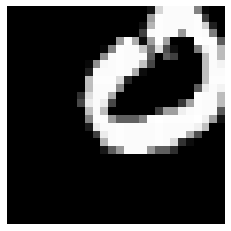

In [ ]:
# random crop & reflected
transform = transforms.Compose([transforms.RandomCrop(size=28,padding=5), transforms.ToTensor(),transforms.Normalize(mean=(0), std=(1))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,shuffle=True, num_workers=2)

dataiter = iter(trainloader)
images, labels = dataiter.next()


plt.imshow(images[0][0],cmap='gray')
plt.axis('off');

images.shape

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0), std=(1))])


trainset = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1,shuffle=True, num_workers=2)

dataiter = iter(trainloader)
images, labels = dataiter.next()

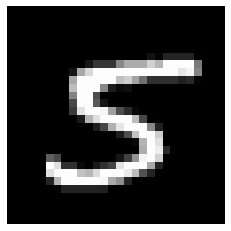

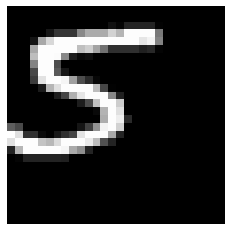

torch.Size([1, 1, 28, 28])

In [ ]:
transform_crop = transforms.Compose([transforms.ToPILImage(),transforms.RandomCrop(size=28,padding=5), transforms.ToTensor(),transforms.Normalize(mean=(0), std=(1))])

img = transform_crop(images[0])


plt.imshow(images[0][0],cmap='gray')
plt.axis('off');
plt.show();

plt.imshow(img[0],cmap='gray')
plt.axis('off');
plt.show();
images.shape

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
class AugmentationSiameseDataset(Dataset):
    def __init__(self):

        # initial transformations
        self.transform = transforms.Compose([  transforms.ToTensor(),transforms.Normalize(mean=(0), std=(1))   ])

        # augmentations
        self.augmentations = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.RandomCrop(size=28,padding=5),
                                                 transforms.RandomRotation(30),
                                                 transforms.ToTensor()])
                                                #  AddGaussianNoise(0.,0.1)])

        # original dataset
        self.trainset = torchvision.datasets.MNIST(root='./data', train=True,download=True, transform=self.transform)
        self.len = len(self.trainset)

        # original trainloaders
        self.trainloader1 = torch.utils.data.DataLoader(self.trainset, batch_size=1,shuffle=True)
        self.trainloader2 = torch.utils.data.DataLoader(self.trainset, batch_size=1,shuffle=True)
        self.reset_iterators() 

    def reset_iterators(self):
        # original iterator
        self.iter1 = iter(self.trainloader1)
        self.iter2 = iter(self.trainloader2)
        self.counter = 0

        
    def __len__(self):
        # same as the legth of the original dataset
        return self.len

    def __getitem__(self, idx):

        # iterations
        if self.counter == self.len:
          self.reset_iterators()
        else:
          self.counter +=1

        # first image
        img1, _ = next(self.iter1)

        # remove the batch dim
        img1 = img1[0]
        
        if torch.rand(1)>0.2: 
          # hard example - augment the current image
          img2 = self.augmentations(img1)
          label = 1
        else: 
          # easy example - sample from all dataset
          img2, label2 = next(self.iter2)
          img2 = img2[0]
          label = 0 

        # return output
        return img1,img2,label


In [ ]:
class Siamese(nn.Module):

    def __init__(self):
        super(Siamese,self).__init__()

        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        
        self.pool1 = nn.MaxPool2d( kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d( kernel_size=3)
        
        self.lin1 = nn.Linear(144, 64)
        self.lin2 = nn.Linear(64, 32)
        self.lin3 = nn.Linear(32, 10)
        
    def forward_once(self,x):
        
        # forwarding the input through the layers
          
        out = self.pool1(nn.functional.relu(self.conv1(x)))
        out = self.pool2(nn.functional.relu(self.conv2(out)))
        
        out = out.view(-1,144)
        
        out = nn.functional.relu(self.lin1(out))
        out = nn.functional.relu(self.lin2(out))
        out = self.lin3(out)
        
        return out
    
    def forward(self, x1, x2):    
        
        # doing the forwarding twice so as to obtain the same functions as that of twin networks
        
        out1 = self.forward_once(x1)
        out2 = self.forward_once(x2)
        
        return out1, out2

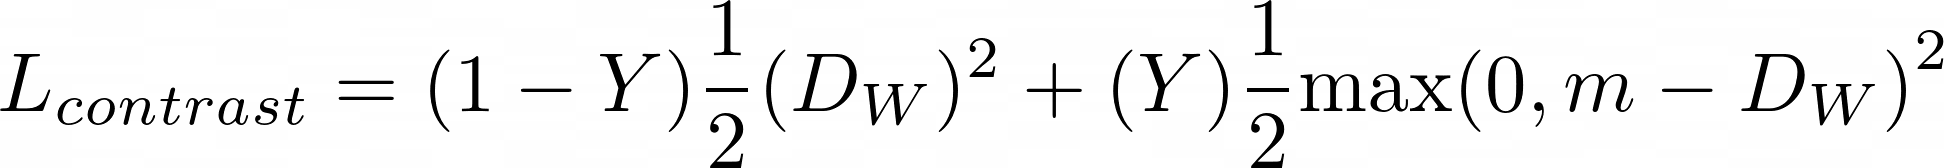

In [ ]:
class ContrastiveLoss(nn.Module):
 
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss_contrastive =  (label) * torch.pow(euclidean_distance, 2) + (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        return torch.mean(loss_contrastive)

In [ ]:
ds = AugmentationSiameseDataset()
tl = torch.utils.data.DataLoader(ds,batch_size=128)

model = Siamese().to(DEVICE)
criterion = ContrastiveLoss()
Optimizer = torch.optim.Adam(model.parameters(),lr = 0.001 )

In [ ]:
img1,img2,label = next(iter(tl))

output1,output2 = model(img1.to(DEVICE),img2.to(DEVICE))

criterion(output1,output2,label.to(DEVICE))


tensor(1.9968, device='cuda:0', grad_fn=<MeanBackward0>)

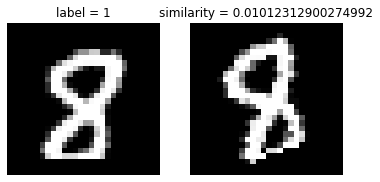

In [ ]:
counter = 0
for imgs1,imgs2,label in tl:
  output1,output2 = model(imgs1,imgs2)
  distance = nn.functional.pairwise_distance(output1,output2)

  plt.subplot(1,2,1)
  plt.imshow(imgs1[0][0],cmap='gray')
  plt.axis('off')
  plt.title('label = ' + str(label[0].item()) )

  plt.subplot(1,2,2)
  plt.imshow(imgs2[0][0],cmap='gray')
  plt.axis('off')
  plt.title('similarity = ' + str(distance[0].item()) )

  break

In [ ]:
for epoch in range(0,20):
    losses = []
    for data in tl:
   
        img1  = data[0].to(DEVICE)
        img2  = data[1].to(DEVICE)
        label = data[2].to(DEVICE)
    
        Optimizer.zero_grad()
        
        output1,output2 = model(img1,img2)
        
        loss = criterion(output1,output2,label)        
        loss.backward()
        
        losses.append(loss.item())
        Optimizer.step()
    
      # printing the training errors
        if len(losses)%100 == 0:
          print("[{}/{}] Mean loss = {}".format(epoch,len(losses),np.mean(losses)))


0/100 Mean loss = 0.8862018293142319
0/200 Mean loss = 0.7030246895551682
0/300 Mean loss = 0.6128834021091462
0/400 Mean loss = 0.5570358145982027
1/100 Mean loss = 0.36339778423309327
1/200 Mean loss = 0.3499831992387772
1/300 Mean loss = 0.3422537751495838
1/400 Mean loss = 0.33448208335787055
2/100 Mean loss = 0.3053423854708672
2/200 Mean loss = 0.3013738688081503
2/300 Mean loss = 0.2964136084417502
2/400 Mean loss = 0.2927210739254951
4/100 Mean loss = 0.28373642459511755
4/200 Mean loss = 0.2797082281857729
4/300 Mean loss = 0.27563230350613593
4/400 Mean loss = 0.2730008362978697
6/100 Mean loss = 0.25857206240296365
6/200 Mean loss = 0.25802531994879246
6/300 Mean loss = 0.2581936299304167
6/400 Mean loss = 0.2564614053815603
8/100 Mean loss = 0.25071453213691713
8/200 Mean loss = 0.2473609021306038
8/300 Mean loss = 0.24668731639782587
8/400 Mean loss = 0.2431569430604577
10/100 Mean loss = 0.24053986087441445
10/200 Mean loss = 0.23986978515982627
10/300 Mean loss = 0.23916

KeyboardInterrupt: ignored

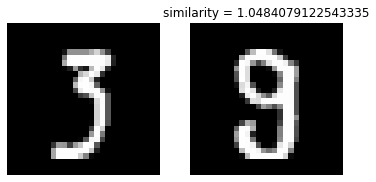

In [ ]:
counter = 0
for imgs1,imgs2,label in tl:
  imgs1 = imgs1[0:1]
  imgs2 = imgs2[10:11]

  output1,output2 = model(imgs1.to(DEVICE),imgs2.to(DEVICE))
  distance = nn.functional.pairwise_distance(output1,output2)

  plt.subplot(1,2,1)
  plt.imshow(imgs1[0][0],cmap='gray')
  plt.axis('off')
  # plt.title('label = ' + str(label[0].item()) )

  plt.subplot(1,2,2)
  plt.imshow(imgs2[0][0],cmap='gray')
  plt.axis('off')
  plt.title('similarity = ' + str(distance[0].item()) )

  break

In [ ]:
nn.functional.pairwise_distance(   output1,output2 )[0]

tensor(2.1510, grad_fn=<SelectBackward>)

In [ ]:
torch.pow(torch.sum(torch.pow((output1[0]-output2[0]),2)),0.5)

tensor(2.1510, grad_fn=<PowBackward0>)